In [37]:
import yfinance as yf
import pandas as pd
import re
import time
import numpy as np
import holidays
from datetime import datetime, timedelta
from scipy.stats import skew, kurtosis
import warnings
pd.set_option('display.max_columns', None)

# Suppress warnings
warnings.filterwarnings("ignore")

In [2]:
calendar = pd.read_csv('earnings_weekly_expiration_table_full.csv')
calendar

,id,ticker_id,earnings_date,eps_estimate,reported_eps,surprise,dte,gap_strikes,gap_before_close,gap_after_open,range_before_strikes,range_after_strikes,ticker,strike_width,weekly_expiration
0,2,2,2025-06-10 20:00:00,0.00,0.00,0.0000,3,NaN,NaN,NaN,NaN,NaN,AVGO,5.0,1
1,3,2,2025-03-05 10:00:00,0.00,0.00,0.0000,2,NaN,NaN,NaN,NaN,NaN,AVGO,5.0,1
2,4,2,2024-12-05 21:00:00,0.00,0.00,0.0000,1,NaN,NaN,NaN,NaN,NaN,AVGO,5.0,1
3,5,2,2024-08-29 10:00:00,1.20,0.00,0.0000,1,NaN,NaN,NaN,NaN,NaN,AVGO,5.0,1
4,6,2,2024-06-12 20:00:00,10.84,10.96,0.0107,2,4.29,149.55,171.0,0.65,1.67,AVGO,5.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6505,6507,554,2023-08-08 11:00:00,1.32,1.41,0.0719,9,NaN,NaN,NaN,NaN,NaN,ZTS,NaN,0
6506,6508,554,2023-05-04 11:00:00,1.26,1.31,0.0389,14,NaN,NaN,NaN,NaN,NaN,ZTS,NaN,0
6507,6509,554,2023-02-14 12:00:00,1.05,1.15,0.0990,2,NaN,NaN,NaN,NaN,NaN,ZTS,NaN,0
6508,6510,554,2022-11-03 11:00:00,1.24,1.21,-0.0207,14,NaN,NaN,NaN,NaN,NaN,ZTS,NaN,0


In [3]:
def next_working_day(date):
    us_holidays = holidays.UnitedStates()
    next_day = date + timedelta(days=1)
    
    # Keep adding days until we find a weekday that is not a holiday
    while next_day.weekday() >= 5 or next_day in us_holidays:
        next_day += timedelta(days=1)
        
    return next_day

In [4]:
calendar['earnings_date'] = pd.to_datetime(calendar['earnings_date'])
calendar['next_work_day'] = calendar['earnings_date'].apply(next_working_day)

In [5]:
calendar

,id,ticker_id,earnings_date,eps_estimate,reported_eps,surprise,dte,gap_strikes,gap_before_close,gap_after_open,range_before_strikes,range_after_strikes,ticker,strike_width,weekly_expiration,next_work_day
0,2,2,2025-06-10 20:00:00,0.00,0.00,0.0000,3,NaN,NaN,NaN,NaN,NaN,AVGO,5.0,1,2025-06-11 20:00:00
1,3,2,2025-03-05 10:00:00,0.00,0.00,0.0000,2,NaN,NaN,NaN,NaN,NaN,AVGO,5.0,1,2025-03-06 10:00:00
2,4,2,2024-12-05 21:00:00,0.00,0.00,0.0000,1,NaN,NaN,NaN,NaN,NaN,AVGO,5.0,1,2024-12-06 21:00:00
3,5,2,2024-08-29 10:00:00,1.20,0.00,0.0000,1,NaN,NaN,NaN,NaN,NaN,AVGO,5.0,1,2024-08-30 10:00:00
4,6,2,2024-06-12 20:00:00,10.84,10.96,0.0107,2,4.29,149.55,171.0,0.65,1.67,AVGO,5.0,1,2024-06-13 20:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6505,6507,554,2023-08-08 11:00:00,1.32,1.41,0.0719,9,NaN,NaN,NaN,NaN,NaN,ZTS,NaN,0,2023-08-09 11:00:00
6506,6508,554,2023-05-04 11:00:00,1.26,1.31,0.0389,14,NaN,NaN,NaN,NaN,NaN,ZTS,NaN,0,2023-05-05 11:00:00
6507,6509,554,2023-02-14 12:00:00,1.05,1.15,0.0990,2,NaN,NaN,NaN,NaN,NaN,ZTS,NaN,0,2023-02-15 12:00:00
6508,6510,554,2022-11-03 11:00:00,1.24,1.21,-0.0207,14,NaN,NaN,NaN,NaN,NaN,ZTS,NaN,0,2022-11-04 11:00:00


In [6]:
avgo_rows = calendar.loc[calendar['ticker'] == 'AVGO']
avgo_rows

,id,ticker_id,earnings_date,eps_estimate,reported_eps,surprise,dte,gap_strikes,gap_before_close,gap_after_open,range_before_strikes,range_after_strikes,ticker,strike_width,weekly_expiration,next_work_day
0,2,2,2025-06-10 20:00:00,0.00,0.00,0.0000,3,NaN,NaN,NaN,NaN,NaN,AVGO,5.0,1,2025-06-11 20:00:00
1,3,2,2025-03-05 10:00:00,0.00,0.00,0.0000,2,NaN,NaN,NaN,NaN,NaN,AVGO,5.0,1,2025-03-06 10:00:00
2,4,2,2024-12-05 21:00:00,0.00,0.00,0.0000,1,NaN,NaN,NaN,NaN,NaN,AVGO,5.0,1,2024-12-06 21:00:00
3,5,2,2024-08-29 10:00:00,1.20,0.00,0.0000,1,NaN,NaN,NaN,NaN,NaN,AVGO,5.0,1,2024-08-30 10:00:00
4,6,2,2024-06-12 20:00:00,10.84,10.96,0.0107,2,4.29,149.55,171.00,0.65,1.67,AVGO,5.0,1,2024-06-13 20:00:00
5,7,2,2024-03-07 21:00:00,10.29,10.99,0.0678,1,-0.31,139.72,138.20,0.59,2.23,AVGO,5.0,1,2024-03-08 21:00:00
6,8,2,2023-12-07 21:00:00,10.98,11.06,0.0071,1,0.04,92.10,92.28,0.41,0.56,AVGO,5.0,1,2023-12-08 21:00:00
7,9,2,2023-08-31 20:00:00,10.42,10.54,0.0112,1,-0.42,92.29,90.19,0.79,0.74,AVGO,5.0,1,2023-09-01 20:00:00
8,10,2,2023-06-01 20:00:00,10.08,10.32,0.0236,1,0.01,79.00,79.06,0.41,0.73,AVGO,5.0,1,2023-06-02 20:00:00
9,11,2,2023-03-02 21:00:00,10.10,10.33,0.0226,1,0.23,59.58,60.75,0.22,0.55,AVGO,5.0,1,2023-03-03 21:00:00


In [7]:
# Create the 'date' column based on the 'earnings_date' column
calendar['date'] = calendar['earnings_date'].apply(
    lambda x: x.date() - pd.Timedelta(days=1) if x.time() <= pd.Timestamp('13:00:00').time() else x.date()
)
#df_all_market_earnings['date'] = df_all_market_earnings['earnings_date'].dt.date

In [8]:
calendar

,id,ticker_id,earnings_date,eps_estimate,reported_eps,surprise,dte,gap_strikes,gap_before_close,gap_after_open,range_before_strikes,range_after_strikes,ticker,strike_width,weekly_expiration,next_work_day,date
0,2,2,2025-06-10 20:00:00,0.00,0.00,0.0000,3,NaN,NaN,NaN,NaN,NaN,AVGO,5.0,1,2025-06-11 20:00:00,2025-06-10
1,3,2,2025-03-05 10:00:00,0.00,0.00,0.0000,2,NaN,NaN,NaN,NaN,NaN,AVGO,5.0,1,2025-03-06 10:00:00,2025-03-04
2,4,2,2024-12-05 21:00:00,0.00,0.00,0.0000,1,NaN,NaN,NaN,NaN,NaN,AVGO,5.0,1,2024-12-06 21:00:00,2024-12-05
3,5,2,2024-08-29 10:00:00,1.20,0.00,0.0000,1,NaN,NaN,NaN,NaN,NaN,AVGO,5.0,1,2024-08-30 10:00:00,2024-08-28
4,6,2,2024-06-12 20:00:00,10.84,10.96,0.0107,2,4.29,149.55,171.0,0.65,1.67,AVGO,5.0,1,2024-06-13 20:00:00,2024-06-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6505,6507,554,2023-08-08 11:00:00,1.32,1.41,0.0719,9,NaN,NaN,NaN,NaN,NaN,ZTS,NaN,0,2023-08-09 11:00:00,2023-08-07
6506,6508,554,2023-05-04 11:00:00,1.26,1.31,0.0389,14,NaN,NaN,NaN,NaN,NaN,ZTS,NaN,0,2023-05-05 11:00:00,2023-05-03
6507,6509,554,2023-02-14 12:00:00,1.05,1.15,0.0990,2,NaN,NaN,NaN,NaN,NaN,ZTS,NaN,0,2023-02-15 12:00:00,2023-02-13
6508,6510,554,2022-11-03 11:00:00,1.24,1.21,-0.0207,14,NaN,NaN,NaN,NaN,NaN,ZTS,NaN,0,2022-11-04 11:00:00,2022-11-02


In [9]:
calendar.to_csv('calendar.csv', index=False)

In [35]:
volatiles = pd.read_csv('volatile_top_tickers_1.csv')
volatiles.head(50)

,ticker,mean_gap,std_dev_gap,var_gap,min_gap,max_gap,count,escalones_unit,strike_width
0,BKNG,24.28,22.40,501.75,0.7,63.0,8,"[45.4, 40.7, 11.7, 63.0, 5.4, 0.7, 14.2, 13.1]",5.0
1,SEDG,22.85,12.80,163.73,4.0,36.4,8,"[4.0, 14.4, 11.9, 35.0, 36.1, 15.7, 29.3, 36.4]",1.0
2,ENPH,19.45,11.49,132.13,0.9,42.0,8,"[0.9, 19.0, 14.0, 16.8, 42.0, 18.4, 25.3, 19.2]",1.0
3,EL,16.41,16.14,260.46,5.5,51.1,7,"[6.3, nan, 19.6, 10.1, 51.1, 7.1, 15.2, 5.5]",1.0
4,ALGN,14.75,8.21,67.47,3.2,25.6,8,"[4.5, 14.3, 22.7, 25.6, 13.0, 21.6, 13.1, 3.2]",2.5
5,DG,11.91,9.49,90.05,2.8,29.0,8,"[4.6, 7.9, 5.3, 29.0, 22.2, 2.8, 16.0, 7.5]",1.0
6,AAP,11.26,12.53,156.89,0.1,32.3,8,"[5.8, 1.0, 3.6, 0.1, 32.3, 4.2, 27.7, 15.4]",1.0
7,EXPE,11.22,8.05,64.76,4.8,28.9,8,"[13.8, 28.9, 13.2, 11.7, 5.2, 6.3, 5.9, 4.8]",1.0
8,DLTR,10.71,8.17,66.77,1.3,20.6,8,"[2.3, 20.5, 1.3, 11.2, 20.6, 2.0, 10.9, 16.9]",1.0
9,DELL,8.89,12.03,144.66,0.0,29.8,8,"[26.0, 29.8, 4.0, 7.7, 0.0, 1.1, 0.6, 1.9]",1.0


In [11]:
df = calendar.merge(volatiles, on='ticker', how='left')

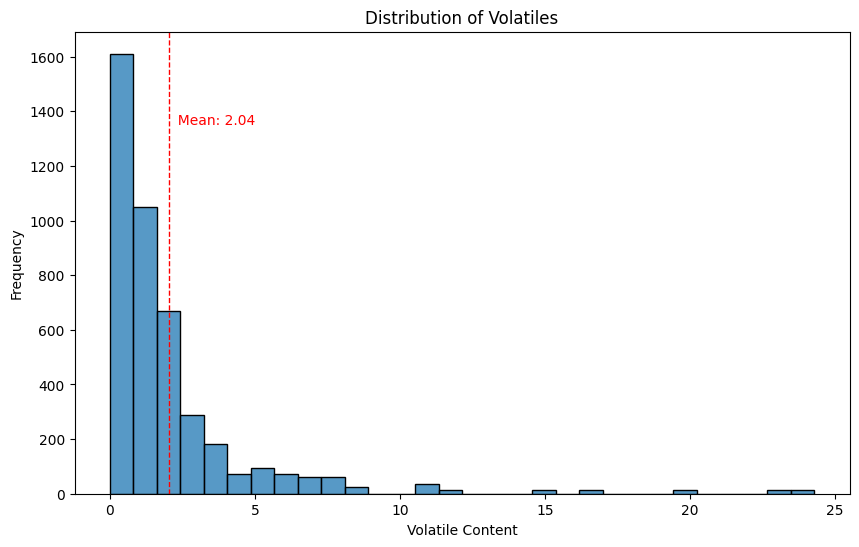

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming your DataFrame is named df and the column is named 'mean_gap'
# Calculate the mean of the 'mean_gap' column
mean_value = df['mean_gap'].mean()

# Plotting the histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['mean_gap'], bins=30)

# Plot a vertical line at the mean value
plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=1)

# Add text annotation for the mean value
plt.text(mean_value, plt.ylim()[1]*0.8, f'  Mean: {mean_value:.2f}', color='red')

# Titles and labels
plt.title('Distribution of Volatiles')
plt.xlabel('Volatile Content')
plt.ylabel('Frequency')

# Show plot
plt.show()

In [34]:
# Count the number of rows with 'mean_gap' values above the mean
count_above_mean = df[df['mean_gap'] > mean_value].shape[0]

# Print the result
print(f"Number of rows with 'mean_gap' above the mean ({mean_value:.2f}): {count_above_mean}")

Number of rows with 'mean_gap' above the mean (2.04): 1197


In [43]:
df = df.dropna(subset=['mean_gap'])
# Calculate skewness and kurtosis
skewness_value = skew(df['mean_gap'])
kurtosis_value = kurtosis(df['mean_gap'])

# Print the results
print(f"Mean of 'mean_gap': {mean_value:.2f}")
print(f"Number of rows with 'mean_gap' above the mean: {count_above_mean}")
print(f"Skewness of 'mean_gap': {skewness_value:.2f}")
print(f"Kurtosis of 'mean_gap (leptokurtic si es >3)': {kurtosis_value:.2f}")

Mean of 'mean_gap': 7.64
Number of rows with 'mean_gap' above the mean: 1197
Skewness of 'mean_gap': 4.11
Kurtosis of 'mean_gap (leptokurtic si es >3)': 22.45


In [12]:
df

,id,ticker_id,earnings_date,eps_estimate,reported_eps,surprise,dte,gap_strikes,gap_before_close,gap_after_open,range_before_strikes,range_after_strikes,ticker,strike_width_x,weekly_expiration,next_work_day,date,mean_gap,std_dev_gap,var_gap,min_gap,max_gap,count,escalones_unit,strike_width_y
0,2,2,2025-06-10 20:00:00,0.00,0.00,0.0000,3,NaN,NaN,NaN,NaN,NaN,AVGO,5.0,1,2025-06-11 20:00:00,2025-06-10,0.8,1.42,2.03,0.0,4.3,8.0,"[4.3, 0.3, 0.1, 0.4, 0.0, 0.4, 0.4, 0.5]",5.0
1,3,2,2025-03-05 10:00:00,0.00,0.00,0.0000,2,NaN,NaN,NaN,NaN,NaN,AVGO,5.0,1,2025-03-06 10:00:00,2025-03-04,0.8,1.42,2.03,0.0,4.3,8.0,"[4.3, 0.3, 0.1, 0.4, 0.0, 0.4, 0.4, 0.5]",5.0
2,4,2,2024-12-05 21:00:00,0.00,0.00,0.0000,1,NaN,NaN,NaN,NaN,NaN,AVGO,5.0,1,2024-12-06 21:00:00,2024-12-05,0.8,1.42,2.03,0.0,4.3,8.0,"[4.3, 0.3, 0.1, 0.4, 0.0, 0.4, 0.4, 0.5]",5.0
3,5,2,2024-08-29 10:00:00,1.20,0.00,0.0000,1,NaN,NaN,NaN,NaN,NaN,AVGO,5.0,1,2024-08-30 10:00:00,2024-08-28,0.8,1.42,2.03,0.0,4.3,8.0,"[4.3, 0.3, 0.1, 0.4, 0.0, 0.4, 0.4, 0.5]",5.0
4,6,2,2024-06-12 20:00:00,10.84,10.96,0.0107,2,4.29,149.55,171.0,0.65,1.67,AVGO,5.0,1,2024-06-13 20:00:00,2024-06-12,0.8,1.42,2.03,0.0,4.3,8.0,"[4.3, 0.3, 0.1, 0.4, 0.0, 0.4, 0.4, 0.5]",5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6505,6507,554,2023-08-08 11:00:00,1.32,1.41,0.0719,9,NaN,NaN,NaN,NaN,NaN,ZTS,NaN,0,2023-08-09 11:00:00,2023-08-07,NaN,NaN,NaN,NaN,NaN,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan]",NaN
6506,6508,554,2023-05-04 11:00:00,1.26,1.31,0.0389,14,NaN,NaN,NaN,NaN,NaN,ZTS,NaN,0,2023-05-05 11:00:00,2023-05-03,NaN,NaN,NaN,NaN,NaN,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan]",NaN
6507,6509,554,2023-02-14 12:00:00,1.05,1.15,0.0990,2,NaN,NaN,NaN,NaN,NaN,ZTS,NaN,0,2023-02-15 12:00:00,2023-02-13,NaN,NaN,NaN,NaN,NaN,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan]",NaN
6508,6510,554,2022-11-03 11:00:00,1.24,1.21,-0.0207,14,NaN,NaN,NaN,NaN,NaN,ZTS,NaN,0,2022-11-04 11:00:00,2022-11-02,NaN,NaN,NaN,NaN,NaN,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan]",NaN


In [13]:
# Convert 'earnings_date' to datetime format
df['date'] = pd.to_datetime(df['date'])

# Sort DataFrame by 'earnings_date'
df_sorted = df.sort_values(by='date', ascending=False)
df_sorted = df_sorted.drop(columns=['strike_width_y', 'id'])

In [14]:
df_sorted

,ticker_id,earnings_date,eps_estimate,reported_eps,surprise,dte,gap_strikes,gap_before_close,gap_after_open,range_before_strikes,range_after_strikes,ticker,strike_width_x,weekly_expiration,next_work_day,date,mean_gap,std_dev_gap,var_gap,min_gap,max_gap,count,escalones_unit
3939,337,2026-04-23 12:00:00,0.00,0.00,0.0000,21,NaN,NaN,NaN,NaN,NaN,HBAN,1.0,0,2026-04-24 12:00:00,2026-04-22,0.24,0.21,0.04,0.0,0.5,5.0,"[0.5, 0.2, 0.0, 0.4, 0.1]"
3940,337,2026-01-22 13:00:00,0.00,0.00,0.0000,28,NaN,NaN,NaN,NaN,NaN,HBAN,1.0,0,2026-01-23 13:00:00,2026-01-21,0.24,0.21,0.04,0.0,0.5,5.0,"[0.5, 0.2, 0.0, 0.4, 0.1]"
4485,383,2026-01-21 13:00:00,0.00,0.00,0.0000,29,NaN,NaN,NaN,NaN,NaN,MTB,NaN,0,2026-01-22 13:00:00,2026-01-20,NaN,NaN,NaN,NaN,NaN,0.0,"[nan, nan, nan, nan, nan, nan]"
5978,510,2026-01-20 14:00:00,0.00,0.00,0.0000,3,NaN,NaN,NaN,NaN,NaN,USB,NaN,1,2026-01-21 14:00:00,2026-01-20,NaN,NaN,NaN,NaN,NaN,0.0,"[nan, nan, nan, nan, nan, nan]"
2647,225,2026-01-21 13:00:00,0.00,0.00,0.0000,29,NaN,NaN,NaN,NaN,NaN,CFG,2.5,0,2026-01-22 13:00:00,2026-01-20,0.30,0.22,0.05,0.0,0.6,6.0,"[0.2, 0.3, 0.2, 0.6, 0.0, 0.5]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4268,364,2021-07-29 10:00:00,0.12,0.26,1.2196,21,NaN,NaN,NaN,NaN,NaN,KIM,2.5,0,2021-07-30 10:00:00,2021-07-28,0.10,0.11,0.01,0.0,0.4,12.0,"[0.1, 0.0, 0.1, 0.1, 0.0, 0.1, 0.2, 0.1, 0.1, ..."
2303,195,2021-07-28 10:00:00,1.60,2.61,0.6330,22,NaN,NaN,NaN,NaN,NaN,BG,5.0,0,2021-07-29 10:00:00,2021-07-27,0.60,0.33,0.11,0.1,1.2,12.0,"[0.9, 0.6, 0.6, 0.3, 0.8, 0.1, 1.2, 0.9, 0.6, ..."
3890,332,2021-07-23 10:00:00,1.94,2.02,0.0432,0,NaN,NaN,NaN,NaN,NaN,HON,2.5,1,2021-07-26 10:00:00,2021-07-22,2.01,1.09,1.18,0.2,4.1,12.0,"[1.9, 2.6, 0.2, 1.8, 2.0, 3.1, 1.2, 2.2, 4.1, ..."
1486,125,2021-02-18 05:00:00,0.49,0.00,0.0000,0,NaN,NaN,NaN,NaN,NaN,GFI,1.0,0,2021-02-19 05:00:00,2021-02-17,0.00,NaN,NaN,0.0,0.0,1.0,[0.0]


In [15]:
fecha = '2024-07-29'

# Convert the date string to a datetime object
date_to_find = pd.to_datetime(fecha)

# Filter the DataFrame for the specified date and where weekly_expiration is 1
tickes_to_trade = df_sorted[(df_sorted['date'] == date_to_find) & (df_sorted['weekly_expiration'] == 1)]

# Sort the filtered DataFrame by 'mean_gap' in descending order
tickes_to_trade_sorted = tickes_to_trade.sort_values(by='mean_gap', ascending=False)

tickes_to_trade_sorted = tickes_to_trade_sorted.reset_index(drop=True)

In [16]:
desired_order = [
    'ticker_id', 'ticker', 'date', 'earnings_date', 'mean_gap', 'std_dev_gap', 'var_gap', 'min_gap', 
    'max_gap','dte', 
    'gap_strikes', 'gap_before_close', 'gap_after_open', 'range_before_strikes', 
    'range_after_strikes',  'strike_width_x', 'weekly_expiration', 
    'next_work_day',  'count', 'escalones_unit', 'eps_estimate', 'reported_eps', 'surprise',
]
tickes_to_trade_sorted = tickes_to_trade_sorted[desired_order]

In [17]:
tickes_to_trade_sorted

,ticker_id,ticker,date,earnings_date,mean_gap,std_dev_gap,var_gap,min_gap,max_gap,dte,gap_strikes,gap_before_close,gap_after_open,range_before_strikes,range_after_strikes,strike_width_x,weekly_expiration,next_work_day,count,escalones_unit,eps_estimate,reported_eps,surprise
0,31,CAT,2024-07-29,2024-07-30 10:00:00,2.41,2.00,3.98,0.9,6.6,3,NaN,NaN,NaN,NaN,NaN,5.0,1,2024-07-31 10:00:00,7.0,"[6.6, nan, 2.9, 1.5, 1.1, 0.9, 2.6, 1.3]",5.54,0.0,0.0
1,238,GLW,2024-07-29,2024-07-30 12:00:00,2.20,1.74,3.01,0.0,5.0,3,NaN,NaN,NaN,NaN,NaN,0.5,1,2024-07-31 12:00:00,7.0,"[2.7, 3.3, 2.7, 1.0, 0.7, 0.0, 5.0]",0.46,0.0,0.0
2,123,MRK,2024-07-29,2024-07-30 12:00:00,2.13,1.05,1.11,0.5,2.9,3,NaN,NaN,NaN,NaN,NaN,1.0,1,2024-07-31 12:00:00,6.0,"[2.7, 2.8, 0.5, 2.9, 1.1, 2.8]",2.15,0.0,0.0
3,164,ADM,2024-07-29,2024-07-30 12:00:00,1.20,1.05,1.09,0.1,2.7,3,NaN,NaN,NaN,NaN,NaN,1.0,1,2024-07-31 12:00:00,8.0,"[0.1, 2.2, 0.7, 0.1, 2.3, 0.5, 1.0, 2.7]",1.22,0.0,0.0
4,54,PFE,2024-07-29,2024-07-30 12:00:00,0.50,0.39,0.15,0.1,1.3,3,NaN,NaN,NaN,NaN,NaN,1.0,1,2024-07-31 12:00:00,8.0,"[0.7, 0.4, 0.2, 0.2, 0.1, 0.5, 1.3, 0.6]",0.46,0.0,0.0
5,470,SPGI,2024-07-29,2024-07-30 12:00:00,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,1,2024-07-31 12:00:00,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan]",3.61,0.0,0.0
6,447,PG,2024-07-29,2024-07-30 12:00:00,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,1,2024-07-31 12:00:00,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan]",1.37,0.0,0.0
7,440,PSX,2024-07-29,2024-07-30 12:00:00,NaN,NaN,NaN,NaN,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,1,2024-07-31 12:00:00,0.0,"[nan, nan, nan, nan, nan, nan, nan, nan]",1.98,0.0,0.0


In [18]:
tickes_to_trade_sorted.to_csv('tickes_to_trade_sorted.csv', index=False)